# Network Traffic Anomaly Detection with LSTM


In [27]:
import os
import glob
import pickle
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pickle
from sklearn.metrics import accuracy_score, classification_report


In [ ]:
# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("Loading CIC-IDS2017 data...")

# Function to load and preprocess CIC-IDS2017 data
def load_cicids_data(data_dir='./data'):
    all_files = glob.glob(os.path.join(data_dir, '*.pcap_ISCX.csv'))
    
    if len(all_files) == 0:
        print("No CIC-IDS2017 .pcap_ISCX files found.")
        return None

    # Load the first 2 files (to prevent excessive memory usage)
    files_to_process = all_files[:2]
    dfs = []

    for file in files_to_process:
        print(f"Processing {file}...")
        df = pd.read_csv(file)
        df = df.dropna()

        # Convert infinity values to NaN, then replace with max * 1000
        numeric_cols = df.select_dtypes(include=[np.number]).columns
        df[numeric_cols] = df[numeric_cols].replace([np.inf, -np.inf], np.nan)
        for col in numeric_cols:
            max_val = df[col].max()
            df[col] = df[col].fillna(max_val * 1000 if not pd.isna(max_val) else 0)

        dfs.append(df)

    # Combine all files
    full_df = pd.concat(dfs, ignore_index=True)
    
    # Ensure the 'label' column is properly formatted
    if 'Label' in full_df.columns:
        full_df.rename(columns={'Label': 'label'}, inplace=True)
    elif ' Label' in full_df.columns:
        full_df.rename(columns={' Label': 'label'}, inplace=True)

    # Convert labels to binary (Benign = 0, Attack = 1)
    full_df['label'] = full_df['label'].apply(lambda x: 0 if x == 'BENIGN' else 1)

    return full_df

# Load CIC-IDS2017 dataset
cicids_df = load_cicids_data()

print("Loading Mininet Flow Data...")

# Load Mininet flow data
mininet_df = pd.read_csv("mininet_flow_data_1741777961.csv")

# Drop unnecessary columns
mininet_df = mininet_df.drop(columns=['switch', 'timestamp', 'collection_time'])

# Convert labels
mininet_df['label'] = mininet_df['label'].map({'BENIGN': 0, 'ATTACK': 1})

# Print feature names before alignment
print("CIC-IDS2017 Features:", list(cicids_df.columns))
print("Mininet Features:", list(mininet_df.columns))

# Manually map Mininet feature names to match CIC-IDS2017 dataset
rename_map = {
    "duration_sec": "Flow Duration",
    "packet_count": "Total Fwd Packets",
    "byte_count": "Total Length of Fwd Packets",
    "bytes_per_sec": "Flow Bytes/s",
    "packets_per_sec": "Flow Packets/s",
    "avg_packet_size": "Average Packet Size"
}
mininet_df.rename(columns=rename_map, inplace=True)

# Find common features after renaming
common_features = list(set(cicids_df.columns) & set(mininet_df.columns))
print(f"Updated common features: {common_features}")

# Filter both datasets to have only common features
cicids_df = cicids_df[common_features]
mininet_df = mininet_df[common_features]

# Merge both datasets
combined_df = pd.concat([cicids_df, mininet_df], ignore_index=True)

# Ensure no NaN values
combined_df = combined_df.fillna(0)

print(f"Final dataset shape: {combined_df.shape}")

# Extract features & labels
X = combined_df.drop(columns=['label'])
y = combined_df['label']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Save the scaler
with open("scaler_combined.pkl", "wb") as f:
    pickle.dump(scaler, f)

# Reshape for LSTM
X_train_reshaped = X_train_scaled.reshape(X_train_scaled.shape[0], 1, X_train_scaled.shape[1])
X_val_reshaped = X_val_scaled.reshape(X_val_scaled.shape[0], 1, X_val_scaled.shape[1])
X_test_reshaped = X_test_scaled.reshape(X_test_scaled.shape[0], 1, X_test_scaled.shape[1])


Loading CIC-IDS2017 data...
Processing ./data/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv...
Processing ./data/Friday-WorkingHours-Morning.pcap_ISCX.csv...
Loading Mininet Flow Data...


FileNotFoundError: [Errno 2] No such file or directory: 'mininet_flow_data_*.csv'

In [4]:
# Build LSTM model
print("Building LSTM model...")

model = Sequential([
    LSTM(128, activation='relu', input_shape=(1, X_train_scaled.shape[1]), return_sequences=True),
    Dropout(0.2),
    LSTM(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Building LSTM model...


2025-03-12 15:46:26.207096: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/home/sandeep/.pyenv/versions/3.9.21/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 1, 128)         │        67,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 118,593 (463.25 KB)

 Trainable params: 118,593 (463.25 KB)

 Non-trainable params: 0 (0.00 B)

In [26]:
print("Training Data Class Distribution:")
print(y_train.value_counts())  # Count of normal (0) and attack (1) samples



Training Data Class Distribution:
label
0    228725
1      2692
Name: count, dtype: int64


In [5]:
# Train the model
print("Training the model...")

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=3, restore_best_weights=True
)

history = model.fit(
    X_train_reshaped, y_train,
    epochs=10,
    batch_size=64,
    validation_data=(X_val_reshaped, y_val),
    callbacks=[early_stopping]
)


Training the model...
Epoch 1/10
3616/3616 ━━━━━━━━━━━━━━━━━━━━ 28s 7ms/step - accuracy: 0.9879 - loss: 0.1080 - val_accuracy: 0.9885 - val_loss: 0.0627
Epoch 2/10
3616/3616 ━━━━━━━━━━━━━━━━━━━━ 24s 7ms/step - accuracy: 0.9883 - loss: 0.0638 - val_accuracy: 0.9885 - val_loss: 0.0621
Epoch 3/10
3616/3616 ━━━━━━━━━━━━━━━━━━━━ 24s 7ms/step - accuracy: 0.9883 - loss: 0.0634 - val_accuracy: 0.9885 - val_loss: 0.0620
Epoch 4/10
3616/3616 ━━━━━━━━━━━━━━━━━━━━ 24s 7ms/step - accuracy: 0.9883 - loss: 0.0631 - val_accuracy: 0.9885 - val_loss: 0.0617
Epoch 5/10
3616/3616 ━━━━━━━━━━━━━━━━━━━━ 24s 7ms/step - accuracy: 0.9883 - loss: 0.0627 - val_accuracy: 0.9885 - val_loss: 0.0615
Epoch 6/10
3616/3616 ━━━━━━━━━━━━━━━━━━━━ 25s 7ms/step - accuracy: 0.9883 - loss: 0.0625 - val_accuracy: 0.9884 - val_loss: 0.0612
Epoch 7/10
3616/3616 ━━━━━━━━━━━━━━━━━━━━ 25s 7ms/step - accuracy: 0.9883 - loss: 0.0624 - val_accuracy: 0.9885 - val_loss: 0.0609
Epoch 8/10
3616/3616 ━━━━━━━━━━━━━━━━━━━━ 25s 7ms/step - accu

In [20]:
model.save("../ml_model/lstm_model_combined.keras")  # Preferred format

# Evaluate on test set
print("Evaluating on test set...")
y_pred_prob = model.predict(X_test_reshaped)
y_pred = (y_pred_prob > 0.5).astype(int).reshape(-1)

accuracy = accuracy_score(y_test, y_pred)
print(f"Test accuracy: {accuracy:.4f}")

# Save feature names
with open("feature_names_combined.pkl", "wb") as f:
    pickle.dump(X.columns.tolist(), f)

print("Model and scaler saved successfully! 🚀")

Evaluating on test set...
2260/2260 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
Test accuracy: 0.9885
Model and scaler saved successfully! 🚀


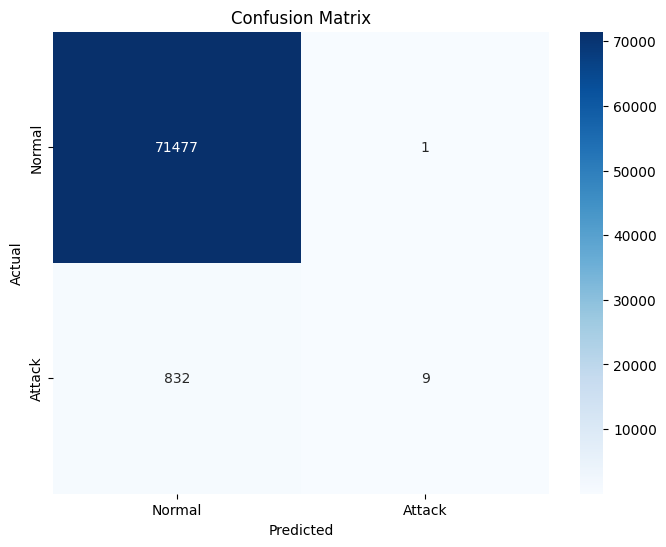

In [21]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Normal', 'Attack'], 
            yticklabels=['Normal', 'Attack'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [22]:
# 11. Save the model
model.save('../ml_model/lstm_model.h5') 
print("Model saved as 'lstm_model.h5'")

with open('../ml_model/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

with open('../ml_model/feature_names.pkl', 'wb') as f:
    pickle.dump(X.columns.tolist(), f)

# 12. Test on new data (simulated here with a sample from test set)
print("\nTesting on sample data...")

# Take a small sample from test set to simulate new data
sample_size = 100
sample_indices = np.random.choice(X_test_scaled.shape[0], sample_size, replace=False)
X_sample = X_test_scaled[sample_indices]
y_sample = y_test.iloc[sample_indices]

# Reshape for LSTM
X_sample_reshaped = X_sample.reshape(X_sample.shape[0], 1, X_sample.shape[1])

# Predict
y_sample_pred_prob = model.predict(X_sample_reshaped)
y_sample_pred = (y_sample_pred_prob > 0.5).astype(int).reshape(-1)

print(f"Sample test accuracy: {accuracy_score(y_sample, y_sample_pred):.4f}")
print("\nSample Classification Report:")
print(classification_report(y_sample, y_sample_pred))



Model saved as 'lstm_model.h5'

Testing on sample data...
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Sample test accuracy: 0.9800

Sample Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        98
           1       0.00      0.00      0.00         2

    accuracy                           0.98       100
   macro avg       0.49      0.50      0.49       100
weighted avg       0.96      0.98      0.97       100



/home/sandeep/.pyenv/versions/3.9.21/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sandeep/.pyenv/versions/3.9.21/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sandeep/.pyenv/versions/3.9.21/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

In [23]:
# 13. Function to be integrated in SDN Application plane
def predict_on_new_data(new_data_path):
    """
    Predict anomalies on new network traffic data
    
    Parameters:
    new_data_path: Path to the CSV file containing new network traffic data
    
    Returns:
    Predictions (0 for normal, 1 for attack)
    """
    # Load new data
    new_df = pd.read_csv(new_data_path, low_memory=False)
    
    # Preprocess
    new_df = new_df.dropna()
    new_df = new_df.replace([np.inf, -np.inf], np.nan)
    new_df = new_df.fillna(new_df.max() * 1000)
    
    # Extract features
    new_X = new_df[numeric_cols]
    
    # Scale
    new_X_scaled = scaler.transform(new_X)
    
    # Reshape for LSTM
    new_X_reshaped = new_X_scaled.reshape(new_X_scaled.shape[0], 1, new_X_scaled.shape[1])
    
    # Predict
    new_pred_prob = model.predict(new_X_reshaped)
    new_pred = (new_pred_prob > 0.5).astype(int).reshape(-1)
    
    return new_pred

# Example usage in SDN controller to test
# new_predictions = predict_on_new_data("path_to_new_traffic_data.csv")
# print(f"Number of normal traffic flows: {(new_predictions == 0).sum()}")
# print(f"Number of detected attacks: {(new_predictions == 1).sum()}")

print("\nNotebook execution complete!")



Notebook execution complete!
